In [1]:
# Goals of notebook:
## 1. Access ChEMBL database
## 2. Shortlist active compounds

In [2]:
# !pip install chembl_webresource_client
from chembl_webresource_client.new_client import new_client
import pandas as pd
import re
from tqdm import tqdm

c:\Users\kheef\AppData\Local\Programs\Python\Python313\Lib\site-packages\chembl_webresource_client\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __version__ = __import__('pkg_resources').get_distribution('chembl_webresource_client').version


In [3]:
#connecting to chemBL
activity = new_client.activity
assay = new_client.assay
molecule = new_client.molecule
target = new_client.target

In [4]:
kras_targets = target.filter(
    target_synonym__icontains="KRAS",
    target_type="SINGLE PROTEIN",
    organism="Homo sapiens"
)

kras_target_ids = [
    t["target_chembl_id"]
    for t in kras_targets
]

print(f"Found {len(kras_target_ids)} KRAS targets")

Found 1 KRAS targets


In [5]:
# Convert to DataFrame for inspection
df_targets = pd.DataFrame([
    {
        "target_chembl_id": t["target_chembl_id"],
        "pref_name": t["pref_name"],
        "organism": t["organism"],
        "target_type": t["target_type"],
        "uniprot_accessions": t.get("target_components", [{}])[0].get("accession")
    }
    for t in kras_targets
])

df_targets.head()

,target_chembl_id,pref_name,organism,target_type,uniprot_accessions
0,CHEMBL2189121,GTPase KRas,Homo sapiens,SINGLE PROTEIN,P01116


In [6]:
# Filter for those targeting G12D mutation

candidate_assays = []

for tid in kras_target_ids:
    assays = assay.filter(target_chembl_id=tid)
    for a in assays:
        desc = (a.get("description") or "").lower()
        if "g12d" in desc:
            candidate_assays.append({
                "assay_chembl_id": a["assay_chembl_id"],
                "assay_type": a.get("assay_type"),
                "description": a.get("description")
            })

print(f"Candidate G12D assays: {len(candidate_assays)}")

Candidate G12D assays: 85


In [7]:
# Convert to DataFrame for inspection

df_assays = pd.DataFrame([
    {
        "assay_chembl_id": c["assay_chembl_id"],
        "assay_type": c["assay_type"],
        "description": c["description"]
    }
    for c in candidate_assays
])

df_assays.sample(5)

,assay_chembl_id,assay_type,description
8,CHEMBL4036898,B,Binding affinity to human N-terminal His/AVi-t...
41,CHEMBL5136565,B,Inhibition of KRAS in human ASPC1 cells harbor...
23,CHEMBL4731138,B,Binding affinity to KRAS G12D mutant (unknown ...
32,CHEMBL4844195,B,Inhibition of KRas G12D mutant (unknown origin...
57,CHEMBL5252362,B,Inhibition of human KRAS G12D mutant in human ...


In [8]:
#all assay types seem labelled as binding

assay_types = df_assays["assay_type"].unique()
print(assay_types)

['B']


In [9]:
descriptions = df_assays["description"]
descriptions.shape

(85,)

In [10]:
descriptions_unique = df_assays["description"].unique()
descriptions_unique.shape

(83,)

In [11]:
# Inspect descriptions

for d in descriptions:
  print(d)

Binding affinity to K-Ras G12D mutant-GDP complex
Binding affinity to KRAS G12D mutant (unknown origin)
Inhibition of biotinylated K-Ras G12D mutant (unknown origin) assessed as reduction in SOS1 (564 to 1049 residues)-mediated BODIPY-GDP-GTP exchange after 1 hr by TR-FRET assay
Inhibition of biotinylated K-Ras G12D mutant (unknown origin) assessed as reduction in SOS1 (564 to 1049 residues)-mediated BODIPY-GDP-GTP exchange after 1 hr in presence of DTT by TR-FRET assay
Binding affinity to human N-terminal His/AVi-tagged biotinylated GTPase KRas G12D mutant (1 to 169 residues) expressed in Escherichia coli BL21 (DE3) in presence of GDP by SPR assay
Binding affinity to human N-terminal His/AVi-tagged biotinylated GTPase KRas G12D mutant (1 to 169 residues) expressed in Escherichia coli BL21 (DE3) in presence of GTP by SPR assay
Binding affinity to human N-terminal His/AVi-tagged biotinylated GTPase KRas G12D mutant (1 to 169 residues) expressed in Escherichia coli BL21 (DE3) assessed as

In [12]:
# Clean up the list of assays and generate a report

import re

# 1) Keywords
exclusion_keywords = [
    "cell", # exclude cellular assays
    "covalent", # exclude assays of covalent binding
]

# 1a) Whitelist (kept even if they match exclusion keywords)
keep_keywords = [
    "Binding affinity to 15N-labelled GDP bound KRas G12D mutant ( 1 to 169 residues) (unknown origin) "
    "expressed in Escherichia coli Rosetta 2 (DE3) cells by 1H/15N- HSQC spectroscopy"
]

# 2) Patterns (escape to be safe)
exclude_pattern = "|".join(map(re.escape, exclusion_keywords))
keep_pattern = "|".join(map(re.escape, keep_keywords))

# 3) Masks
matches_exclusion = df_assays["description"].str.contains(exclude_pattern, case=False, na=False)
matches_keep = df_assays["description"].str.contains(keep_pattern, case=False, na=False)

# Removed if: matches exclusion AND NOT whitelisted
removed_mask = matches_exclusion & ~matches_keep

# Whitelist overrides if: matches exclusion AND matches keep
omitted_from_exclusion_mask = matches_exclusion & matches_keep

# 4) Split
removed_df = df_assays[removed_mask].copy()
df_assays_filtered = df_assays[~removed_mask].copy()
omitted_from_exclusion_df = df_assays[omitted_from_exclusion_mask].copy()

# 5) Reason for removal (only for removed_df)
def find_trigger(text: str):
    t = (text or "").lower()
    for w in exclusion_keywords:
        if w.lower() in t:
            return w
    return None

removed_df["reason_for_removal"] = removed_df["description"].apply(find_trigger)

# 6) Print summary
print(f"Kept: {len(df_assays_filtered)} | Removed: {len(removed_df)} | Omitted from exclusion (whitelist override): {len(omitted_from_exclusion_df)}\n")

# 7) Print omitted-from-exclusion items (whitelist overrides)
if len(omitted_from_exclusion_df) > 0:
    print("--- OMITTED FROM EXCLUSION (WHITELIST OVERRIDE) ---\n")
    for _, row in omitted_from_exclusion_df.iterrows():
        print(f"DESCRIPTION: {row['description']}")
        print("-" * 30)

# 8) Print removed items
print(f"\n--- TOTAL REMOVED: {len(removed_df)} ---\n")
for _, row in removed_df.iterrows():
    reason = row["reason_for_removal"] or "UNKNOWN"
    print(f"REMOVED BY: [{reason.upper()}]")
    print(f"DESCRIPTION: {row['description']}")
    print("-" * 30)


Kept: 63 | Removed: 22 | Omitted from exclusion (whitelist override): 1

--- OMITTED FROM EXCLUSION (WHITELIST OVERRIDE) ---

DESCRIPTION: Binding affinity to 15N-labelled GDP bound KRas G12D mutant ( 1 to 169 residues) (unknown origin) expressed in Escherichia coli Rosetta 2 (DE3) cells by 1H/15N- HSQC spectroscopy
------------------------------

--- TOTAL REMOVED: 22 ---

REMOVED BY: [CELL]
DESCRIPTION: Inhibition of KRAS G12D mutant in human AGS cells assessed as reduction in ERK phosphorylation measured after 3 hrs by Western blot analysis
------------------------------
REMOVED BY: [CELL]
DESCRIPTION: Inhibition of KRas G12D mutant (unknown origin) expressed in HEK293T cells coexpressing GFP-fused CRAF RBD assessed as reduction in Ras-Raf interaction using coelenterazine 400a as substrate incubated for 20 hrs by BRET2 assay
------------------------------
REMOVED BY: [CELL]
DESCRIPTION: Inhibition of KRas G12D mutant (unknown origin) expressed in HEK293T cells coexpressing GFP-fused

In [13]:
df_assays_filtered.head()

,assay_chembl_id,assay_type,description
0,CHEMBL2089529,B,Binding affinity to K-Ras G12D mutant-GDP complex
1,CHEMBL2399317,B,Binding affinity to KRAS G12D mutant (unknown ...
2,CHEMBL4021570,B,Inhibition of biotinylated K-Ras G12D mutant (...
3,CHEMBL4021571,B,Inhibition of biotinylated K-Ras G12D mutant (...
4,CHEMBL4036886,B,Binding affinity to human N-terminal His/AVi-t...


In [14]:
df_assays_filtered.shape

(63, 3)

In [15]:
df_assays_filtered_unique = df_assays_filtered['description'].unique()
df_assays_filtered_unique.shape

(63,)

In [16]:
activities_query = activity.filter(
    assay_chembl_id__in=df_assays_filtered["assay_chembl_id"].unique().tolist()
  ).only(
    'molecule_chembl_id',
    'target_chembl_id',
    'standard_type',
    'standard_value',
    'standard_units',
    'standard_relation',
    'assay_type',
    'confidence_score',
    'canonical_smiles',
    'data_validity_comment'
  )

In [17]:
total_count = len(activities_query)
print(f'Total records found on server: {total_count}')

activity_list = []
for act in tqdm(activities_query, total=total_count, desc="Fetching ChEMBL Data"):
  activity_list.append(act)

df_activities = pd.DataFrame(activity_list)
csv_filename = "KRAS_G12D_chemBL_raw.csv"
df_activities.to_csv(csv_filename, index=False)
print(f'\nDownload complete!')
print(f'Total records saved: {len(df_activities)}')
if not df_activities.empty:
  print(f'Types of measurements found: {df_activities["standard_type"].unique()}')

Total records found on server: 3239


Fetching ChEMBL Data: 100%|██████████| 3239/3239 [00:00<00:00, 3550.80it/s]


Download complete!
Total records saved: 3239
Types of measurements found: ['Kd' 'Activity' 'IC50' 'T1/2' 'K' 'Delta Tm' 'deltaH' 'deltaG' '-TdeltaS'
 'Inhibition' 'Tm' 'kon' 'k_off']


In [18]:
df_activities[['standard_type', 'standard_units']].value_counts()

standard_type  standard_units
IC50           nM                991
k_off          s-1               986
Kd             nM                189
Tm             degrees C          13
K              10^-4/s             9
               10^5/Ms             5
Delta Tm       degrees C           4
Activity       %                   4
K              10^6/Ms             4
Activity       uM                  2
K              10'-2/s             2
T1/2           hr                  2
K              10'6/M/s            2
-TdeltaS       kcal/mol            1
Inhibition     %                   1
Activity       mM                  1
deltaG         kcal/mol            1
deltaH         kcal/mol            1
Name: count, dtype: int64

In [19]:
# Filter to rows where the standardized relation is "="

rel = df_activities["standard_relation"]
df_eq = df_activities.loc[rel.eq("=")].copy()

# Check counts again (standard_type, standard_units) after filtering
df_eq[["standard_type", "standard_units"]].value_counts()


standard_type  standard_units
k_off          s-1               986
IC50           nM                871
Kd             nM                182
Tm             degrees C          13
K              10^-4/s             9
               10^5/Ms             5
Delta Tm       degrees C           4
Activity       %                   4
K              10^6/Ms             4
Activity       uM                  2
K              10'-2/s             2
T1/2           hr                  2
K              10'6/M/s            2
-TdeltaS       kcal/mol            1
Inhibition     %                   1
Activity       mM                  1
deltaG         kcal/mol            1
deltaH         kcal/mol            1
Name: count, dtype: int64

In [20]:
df_activities[['type', 'units']].value_counts()

type      units    
kon       M-1-s-1      986
koff      s-1          986
IC50      nM           963
Kd        nM           173
IC50      uM            28
Kd        uM            14
Tm        degrees C     13
K         10^-4/s        9
          10^5/Ms        5
Activity  %              4
deltaTm   degrees C      4
K         10^6/Ms        4
Activity  uM             2
Kd        mM             2
t1/2      s              2
K         10'-2/s        2
          10'6/M/s       2
-TdeltaS  kcal/mol       1
Activity  mM             1
INH       %              1
deltaH    kcal/mol       1
deltaG    kcal/mol       1
Name: count, dtype: int64

In [21]:
#need to further filter the list of actives here

accepted_types = ["Kd", "IC50"]
df_filtered = df_activities[df_activities["standard_value"].notna() & (df_activities["relation"] == "=") & df_activities["standard_type"].isin(accepted_types)]
df_filtered['standard_value'] = pd.to_numeric(df_filtered['standard_value'], errors='coerce')  # non-numeric -> NaN
df_filtered = df_filtered[df_filtered['standard_value'].notna()]  # keep only rows where conversion succeeded

C:\Users\kheef\AppData\Local\Temp\ipykernel_45548\1438877789.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['standard_value'] = pd.to_numeric(df_filtered['standard_value'], errors='coerce')  # non-numeric -> NaN


In [22]:
#number of known actives in file

print(df_filtered["molecule_chembl_id"].nunique())

574


In [23]:
#only IC50 for plots, scale is nM

df_IC50_nM = df_filtered[df_filtered["standard_type"] == "IC50"]
print(df_IC50_nM["molecule_chembl_id"].nunique())

540


In [24]:
df_IC50_nM["standard_value"].head()

6        1.6
7       11.0
8        6.1
9       19.0
10    1790.0
Name: standard_value, dtype: float64

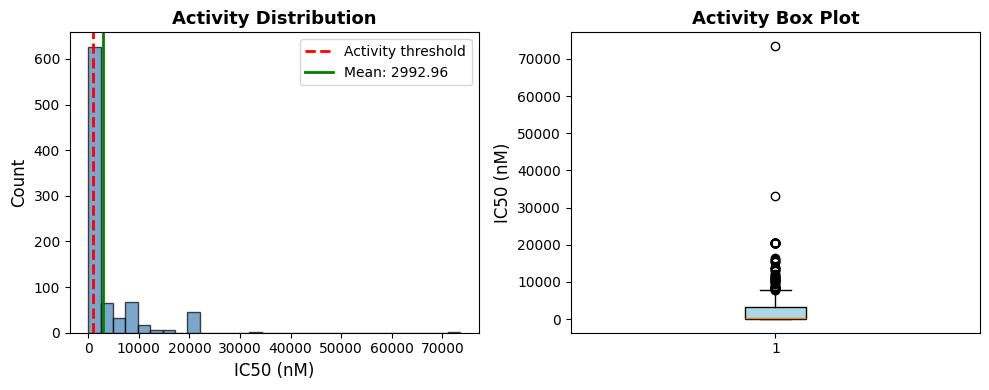

In [25]:
# ============================================================
# ACTIVITY DISTRIBUTION VISUALIZATION
# ============================================================

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogram
ax1 = axes[0]
ax1.hist(df_IC50_nM["standard_value"], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(x=1000.0, color='red', linestyle='--', linewidth=2, label='Activity threshold')
ax1.axvline(x=df_IC50_nM["standard_value"].mean(), color='green', linestyle='-', linewidth=2, label=f'Mean: {df_IC50_nM["standard_value"].mean():.2f}')
ax1.set_xlabel('IC50 (nM)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Activity Distribution', fontsize=13, fontweight='bold')
ax1.legend()

# Box plot
ax2 = axes[1]
bp = ax2.boxplot(df_IC50_nM["standard_value"], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
ax2.set_ylabel('IC50 (nM)', fontsize=12)
ax2.set_title('Activity Box Plot', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/activity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
# pIC50 statistics

import numpy as np
import pandas as pd

# If df_IC50_nM was created by filtering, make it an explicit copy first
df_IC50_nM = df_IC50_nM.copy()

# Ensure standard_value is numeric
df_IC50_nM["standard_value"] = pd.to_numeric(df_IC50_nM["standard_value"], errors="coerce")

# pIC50 from IC50 in nM: pIC50 = 9 - log10(IC50_nM)
mask = df_IC50_nM["standard_value"] > 0
df_IC50_nM.loc[mask, "pIC50"] = 9 - np.log10(df_IC50_nM.loc[mask, "standard_value"])
df_IC50_nM.loc[~mask, "pIC50"] = np.nan  # non-positive / missing become NaN

df_IC50_nM[["standard_value", "standard_units", "pIC50"]].head()

,standard_value,standard_units,pIC50
6,1.6,nM,8.795880
7,11.0,nM,7.958607
8,6.1,nM,8.214670
9,19.0,nM,7.721246
10,1790.0,nM,5.747147


In [27]:
df_IC50_nM.head()

,assay_type,canonical_smiles,data_validity_comment,molecule_chembl_id,relation,standard_relation,standard_type,standard_units,standard_value,target_chembl_id,type,units,value,pIC50
6,B,CC[C@H](C)[C@@H]1NC(=O)[C@H](Cc2ccc(O)cc2)NC(=...,None,CHEMBL4072295,=,=,IC50,nM,1.6,CHEMBL2189121,IC50,nM,1.6,8.795880
7,B,CC[C@H](C)[C@@H]1NC(=O)[C@H](Cc2ccc(O)cc2)NC(=...,None,CHEMBL4100766,=,=,IC50,nM,11.0,CHEMBL2189121,IC50,nM,11.0,7.958607
8,B,CC[C@H](C)[C@@H]1NC(=O)[C@H](Cc2ccc(O)cc2)NC(=...,None,CHEMBL4082777,=,=,IC50,nM,6.1,CHEMBL2189121,IC50,nM,6.1,8.214670
9,B,CC[C@H](C)[C@@H]1NC(=O)[C@H](Cc2ccc(O)cc2)NC(=...,None,CHEMBL4075048,=,=,IC50,nM,19.0,CHEMBL2189121,IC50,nM,19.0,7.721246
10,B,CC[C@H](C)[C@@H]1NC(=O)[C@H](Cc2ccc(O)cc2)NC(=...,None,CHEMBL4084139,=,=,IC50,nM,1790.0,CHEMBL2189121,IC50,nM,1790.0,5.747147


In [28]:
df_IC50_nM.shape

(871, 14)

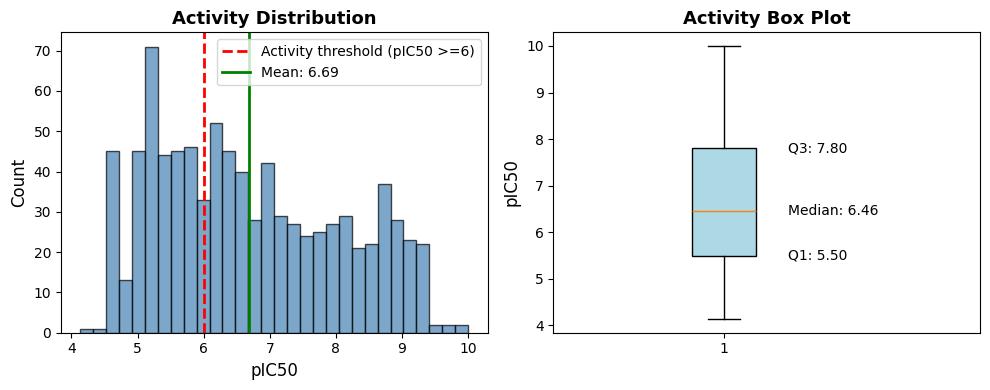

In [29]:
# ============================================================
# ACTIVITY DISTRIBUTION VISUALIZATION
# ============================================================

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogram
ax1 = axes[0]
ax1.hist(df_IC50_nM["pIC50"], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(x=6, color='red', linestyle='--', linewidth=2, label='Activity threshold (pIC50 >=6)')
ax1.axvline(x=df_IC50_nM["pIC50"].mean(), color='green', linestyle='-', linewidth=2, label=f'Mean: {df_IC50_nM["pIC50"].mean():.2f}')
ax1.set_xlabel('pIC50', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Activity Distribution', fontsize=13, fontweight='bold')
ax1.legend()

# Box plot
ax2 = axes[1]
bp = ax2.boxplot(df_IC50_nM["pIC50"], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
ax2.set_ylabel('pIC50', fontsize=12)
ax2.set_title('Activity Box Plot', fontsize=13, fontweight='bold')
# ---- show median, Q1, Q3 on the box plot ----
q1, med, q3 = np.percentile(df_IC50_nM["pIC50"], [25, 50, 75])
# label them at the right side of the axis
x_text = 1.15  # a bit to the right of the box (x=1)
ax2.text(x_text, q1,  f"Q1: {q1:.2f}",  va='center', ha='left')
ax2.text(x_text, med, f"Median: {med:.2f}", va='center', ha='left')
ax2.text(x_text, q3,  f"Q3: {q3:.2f}",  va='center', ha='left')
# make room for the text
ax2.set_xlim(0.6, 1.6)

plt.tight_layout()
plt.savefig('figures/activity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
# Count molecules with pIC50 >= 6 (ignores NaNs automatically)
n_active = df_IC50_nM.loc[df_IC50_nM["pIC50"].ge(6), "molecule_chembl_id"].nunique()
print(f"Number of molecules with pIC50 >= 6: {n_active}")

Number of molecules with pIC50 >= 6: 422
